In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

In [7]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration - Force CPU for MacBook
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# Load datasets
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform_test)

In [4]:
# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
# Class names
class_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")

Training samples: 60000
Test samples: 10000
Number of classes: 10


In [8]:
class FashionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionCNN, self).__init__()
        
        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 28x28 -> 28x28
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 14x14 -> 14x14
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 14x14 -> 7x7
        
        # Classifier layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        
        # Classification
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

# Create model
model = FashionCNN().to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Parameters: {total_params:,}")


Model Parameters: 1,733,194


In [9]:
# 3. TRAINING SETUP
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

num_epochs = 8

# Training history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# 4. TRAINING LOOP
print("\nStarting Training...")
print("=" * 60)

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Print progress
        if (batch_idx + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')
    
    # Calculate epoch metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = correct_test / total_test
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Update learning rate
    scheduler.step()
    
    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f'Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')
    print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
    print("-" * 60)

print("Training completed!")


Starting Training...
Epoch [1/8], Step [200/938], Loss: 0.5755
Epoch [1/8], Step [400/938], Loss: 0.6305
Epoch [1/8], Step [600/938], Loss: 0.5981
Epoch [1/8], Step [800/938], Loss: 0.4325
Epoch [1/8] - 91.4s
Train Loss: 0.6129, Train Acc: 0.7774
Test Loss: 0.3605, Test Acc: 0.8701
LR: 0.001000
------------------------------------------------------------
Epoch [2/8], Step [200/938], Loss: 0.4355
Epoch [2/8], Step [400/938], Loss: 0.5078
Epoch [2/8], Step [600/938], Loss: 0.3910
Epoch [2/8], Step [800/938], Loss: 0.4326
Epoch [2/8] - 88.5s
Train Loss: 0.4169, Train Acc: 0.8533
Test Loss: 0.3124, Test Acc: 0.8844
LR: 0.001000
------------------------------------------------------------
Epoch [3/8], Step [200/938], Loss: 0.3050
Epoch [3/8], Step [400/938], Loss: 0.6448
Epoch [3/8], Step [600/938], Loss: 0.3609
Epoch [3/8], Step [800/938], Loss: 0.4236
Epoch [3/8] - 86.4s
Train Loss: 0.3620, Train Acc: 0.8719
Test Loss: 0.2950, Test Acc: 0.8884
LR: 0.000700
-------------------------------

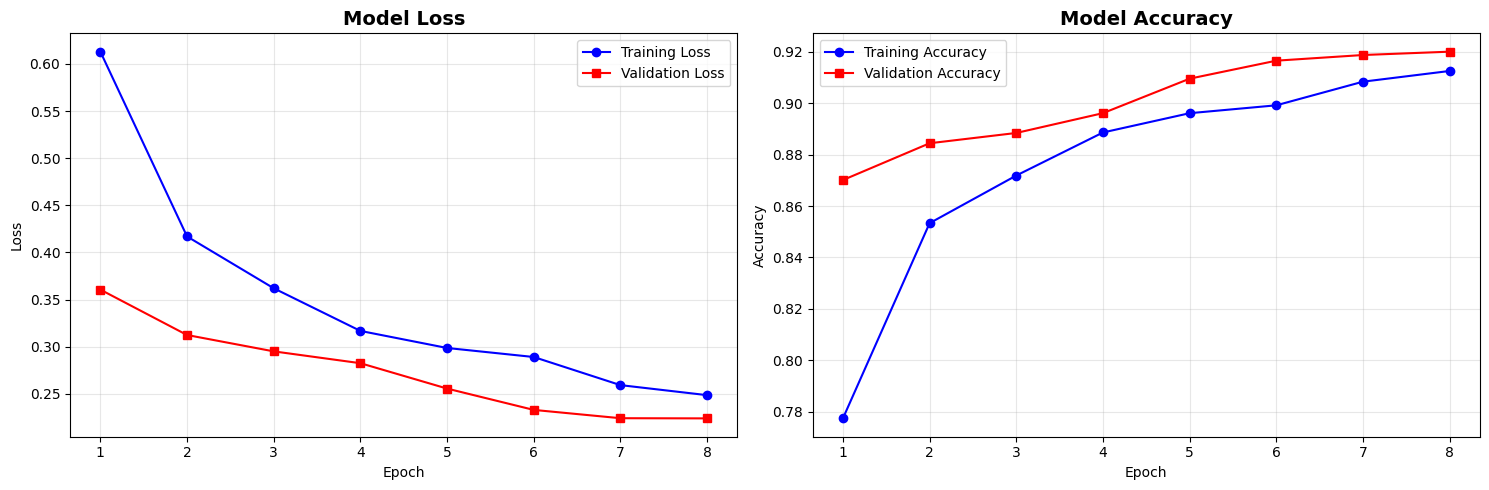

In [13]:
#5. VISUALIZATION - TRAINING HISTORY


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)

# Plot losses
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', marker='o')
ax1.plot(epochs, test_losses, 'r-', label='Validation Loss', marker='s')
ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', marker='o')
ax2.plot(epochs, test_accuracies, 'r-', label='Validation Accuracy', marker='s')
ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# 6. COMPREHENSIVE EVALUATION

print("\nRunning Comprehensive Evaluation...")
print("=" * 60)

model.eval()
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Top-3 accuracy
def calculate_top_k_accuracy(probabilities, labels, k=3):
    top_k_preds = np.argsort(probabilities, axis=1)[:, -k:]
    correct = sum(label in top_k_preds[i] for i, label in enumerate(labels))
    return correct / len(labels)

top3_accuracy = calculate_top_k_accuracy(all_probabilities, all_labels, k=3)

# Confidence analysis
confidences = np.max(all_probabilities, axis=1)
correct_mask = all_predictions == all_labels

print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"Mean Confidence: {confidences.mean():.4f}")
print(f"Confidence (Correct): {confidences[correct_mask].mean():.4f}")
print(f"Confidence (Incorrect): {confidences[~correct_mask].mean():.4f}")


Running Comprehensive Evaluation...
Final Test Accuracy: 0.9200
Top-3 Accuracy: 0.9940
Mean Confidence: 0.9233
Confidence (Correct): 0.9451
Confidence (Incorrect): 0.6726


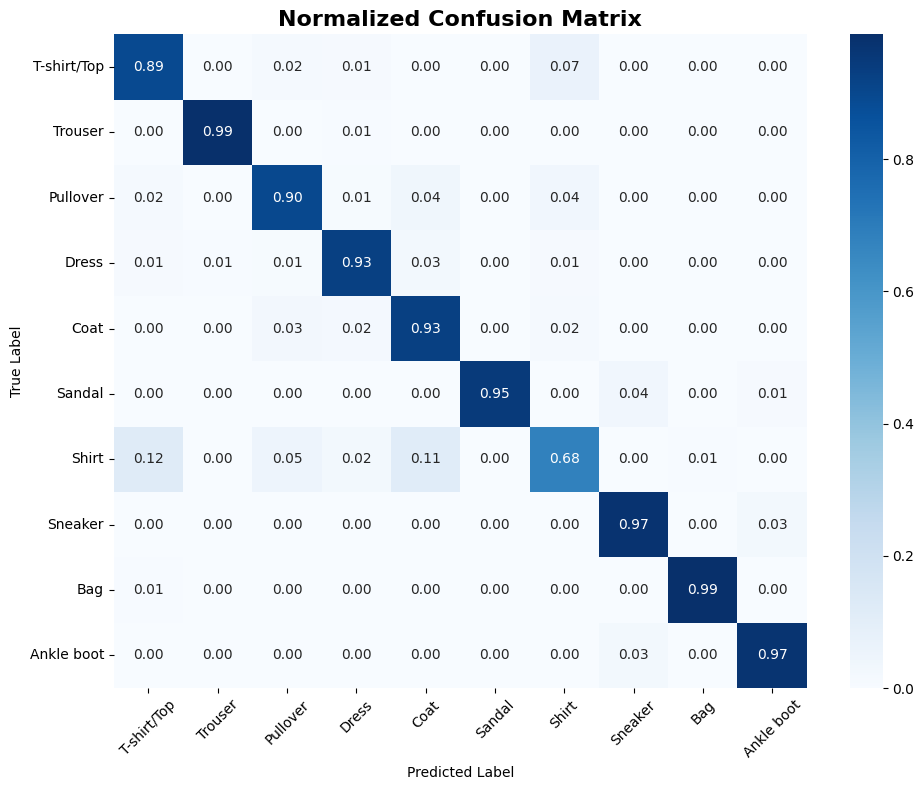

In [15]:
# 7. VISUALIZATION - CONFUSION MATRIX

plt.figure(figsize=(10, 8))
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

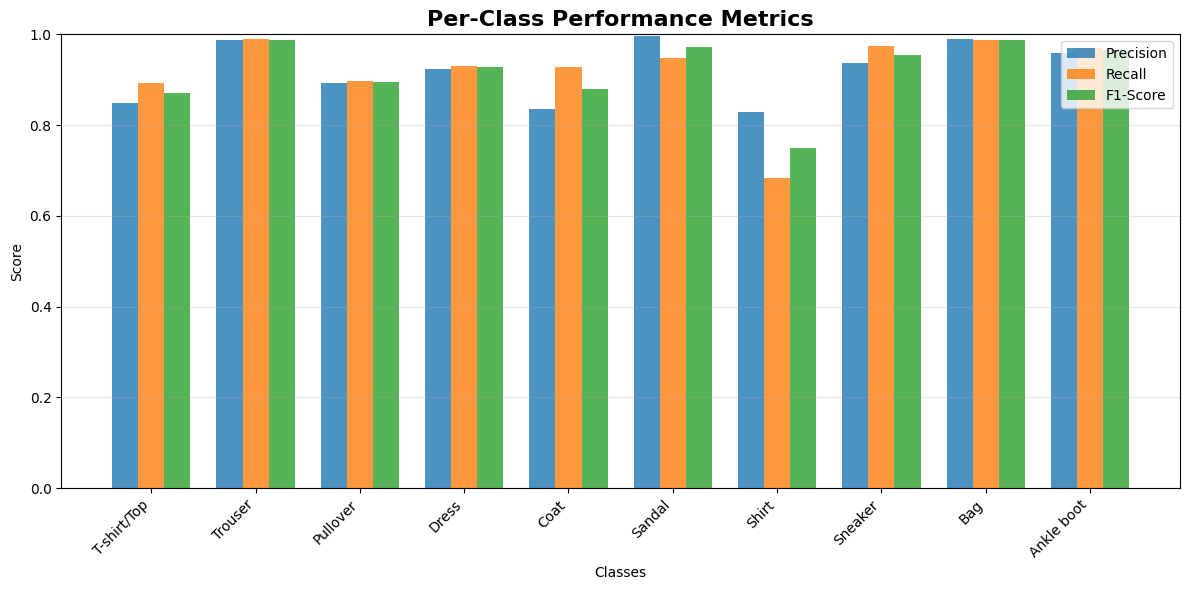


Worst Performing Classes (by F1-Score):
--------------------------------------------------
1. Shirt: 0.749 (n=1000)
2. T-shirt/Top: 0.870 (n=1000)
3. Coat: 0.879 (n=1000)


In [16]:
# 8. VISUALIZATION - PER-CLASS METRICS

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)

# Plot per-class metrics
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
ax.bar(x, recall, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Per-Class Performance Metrics', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Print worst performing classes
class_f1 = list(zip(class_names, f1, support))
class_f1.sort(key=lambda x: x[1])

print("\nWorst Performing Classes (by F1-Score):")
print("-" * 50)
for i, (class_name, f1_score, supp) in enumerate(class_f1[:3]):
    print(f"{i+1}. {class_name}: {f1_score:.3f} (n={supp})")

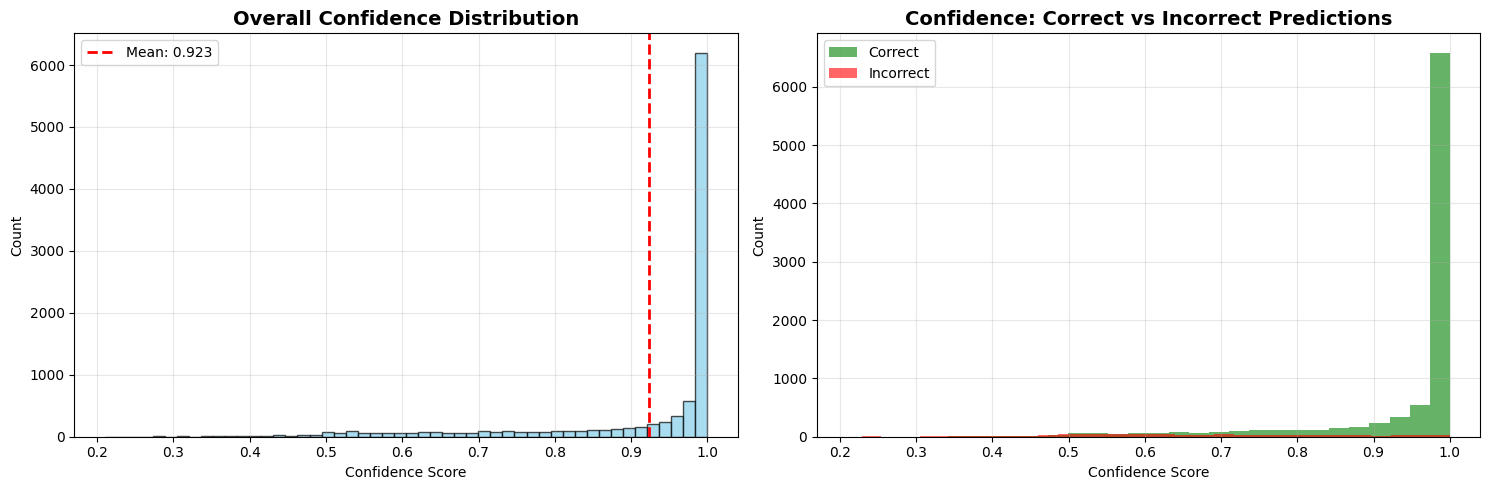

In [17]:
# 9. VISUALIZATION - CONFIDENCE DISTRIBUTION

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall confidence distribution
axes[0].hist(confidences, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0].axvline(confidences.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {confidences.mean():.3f}')
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confidence for correct vs incorrect predictions
axes[1].hist(confidences[correct_mask], bins=30, alpha=0.6, label='Correct', color='green')
axes[1].hist(confidences[~correct_mask], bins=30, alpha=0.6, label='Incorrect', color='red')
axes[1].set_xlabel('Confidence Score')
axes[1].set_ylabel('Count')
axes[1].set_title('Confidence: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




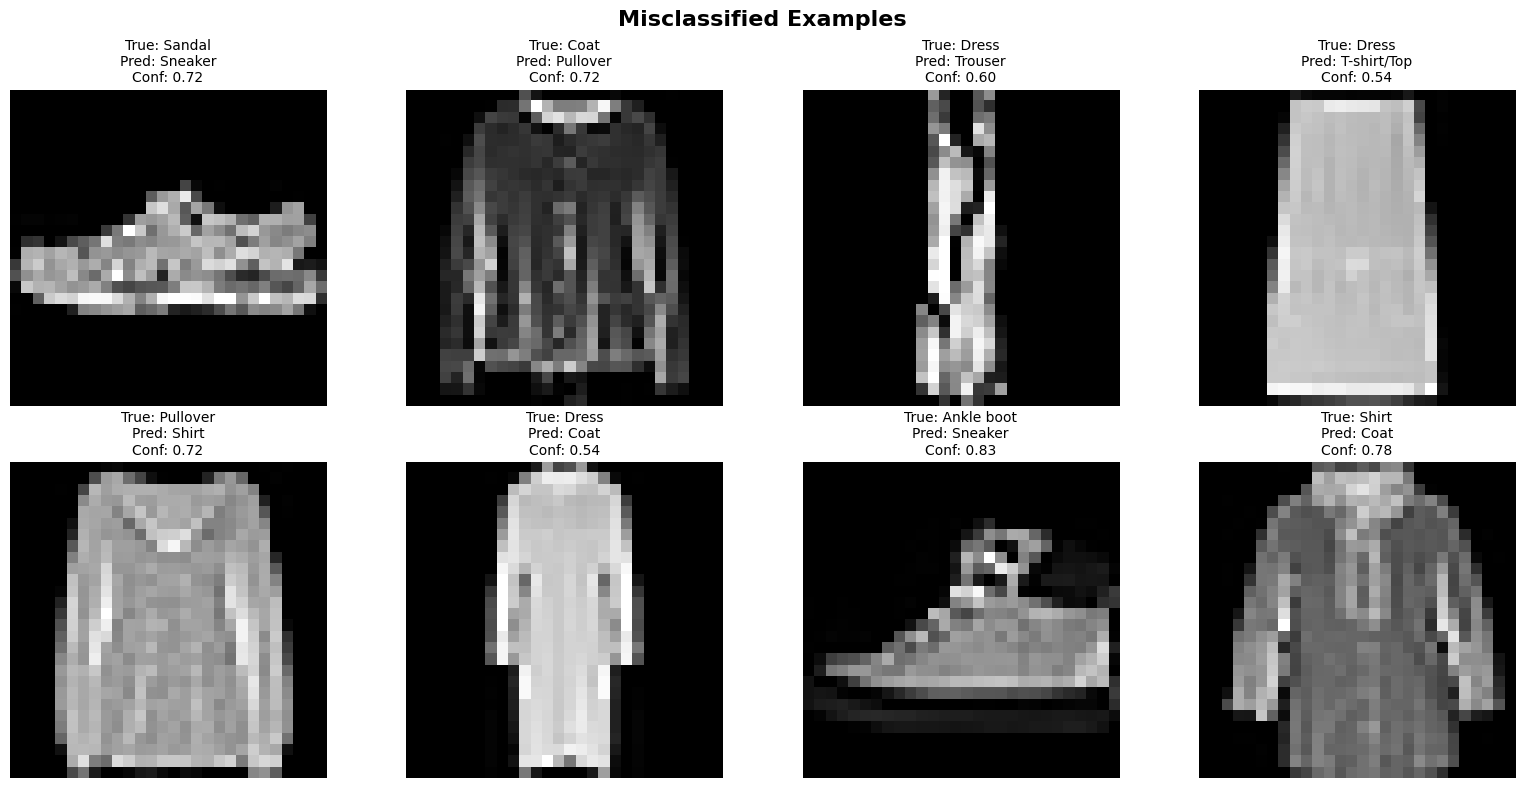

In [18]:
# 10. VISUALIZATION - MISCLASSIFIED EXAMPLES

# Find misclassified examples
misclassified_indices = np.where(all_predictions != all_labels)[0][:8]

if len(misclassified_indices) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(misclassified_indices):
        # Get the original image from test dataset
        image, true_label = test_dataset[idx]
        pred_label = all_predictions[idx]
        confidence = all_probabilities[idx][pred_label]
        
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'True: {class_names[true_label]}\n'
                         f'Pred: {class_names[pred_label]}\n'
                         f'Conf: {confidence:.2f}',
                         fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [19]:
# 11. SAVE MODEL

# Save the trained model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': accuracy,
    'class_names': class_names
}, 'fashion_mnist_model.pth')

print(f"\nModel saved as 'fashion_mnist_model.pth'")
print(f"Final Test Accuracy: {accuracy:.4f}")


Model saved as 'fashion_mnist_model.pth'
Final Test Accuracy: 0.9200


In [20]:

# 12. SUMMARY REPORT

print("\n" + "="*60)
print("FINAL EVALUATION SUMMARY")
print("="*60)
print(f"Model Parameters: {total_params:,}")
print(f"Training Epochs: {num_epochs}")
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"Mean Confidence: {confidences.mean():.4f}")
print(f"Best Performing Class: {class_names[np.argmax(f1)]} (F1: {np.max(f1):.3f})")
print(f"Worst Performing Class: {class_names[np.argmin(f1)]} (F1: {np.min(f1):.3f})")
print("="*60)


FINAL EVALUATION SUMMARY
Model Parameters: 1,733,194
Training Epochs: 8
Final Test Accuracy: 0.9200
Top-3 Accuracy: 0.9940
Mean Confidence: 0.9233
Best Performing Class: Trouser (F1: 0.989)
Worst Performing Class: Shirt (F1: 0.749)
